In [10]:
# 必要なライブラリをインストール
!pip install dalex          # DALEX本体：XAIの主役
!pip install xgboost        # XGBoost：高性能な機械学習モデル
!pip install pandas         # pandas：データを扱うための基本ツール
!pip install numpy          # numpy：数値計算の基礎ライブラリ
!pip install scikit-learn   # scikit-learn：機械学習の定番ライブラリ
!pip install matplotlib     # matplotlib：グラフ描画用

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.2-py3-none-any.whl size=1042898 sha256=f217f6f228a26e3fea4b3b97f55f10e4de8b9e8243f99f286a8f4a85c42dc88a
  Stored in directory: /root/.cache/pip/wheels/17/0a/3a/8c988bdca6acd7ce4aa949726b26c382ad1635e065bf83a175
Successfully built dalex


In [16]:
# ライブラリをインポート（道具箱から必要な道具を取り出すイメージ）
import dalex as dx
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt # プロット用
import plotly.graph_objects as go # プロット用
import japanize_matplotlib  # 日本語表示用
from sklearn.tree import plot_tree # 決定木可視化用


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')  # 不要な警告を非表示に
# バージョン確認（正しくインストールされたかチェック）
print(f"DALEX version: {dx.__version__}")

DALEX version: 1.7.2


In [12]:
# CSVファイルからデータを読み込む
vibration_df = pd.read_csv('vibration_data.csv')
# データフレームの内容を表示する
print(vibration_df)

          RMS      Peak  Crest_Factor  Kurtosis  Skewness  1X_Amplitude  \
0    0.367449  0.756542      2.058906  1.717507 -0.001791      5.383227   
1    0.370038  0.784419      2.119835  1.693268  0.004646     16.574714   
2    0.362522  0.763038      2.104805  1.718465 -0.042212     48.493093   
3    0.373453  0.738931      1.978646  1.692860  0.026596     15.002546   
4    0.363325  0.781913      2.152104  1.703755  0.017600     26.773940   
..        ...       ...           ...       ...       ...           ...   
989  0.601842  1.843311      3.062783  2.496660  0.059412     20.459750   
990  0.621054  1.711213      2.755338  2.424775  0.054242     43.315993   
991  0.674651  2.053610      3.043960  2.481649  0.078789     54.206158   
992  0.638048  1.962351      3.075555  2.477355  0.080800     42.651307   
993  0.619565  1.820200      2.937868  2.501591  0.072281    200.475499   

     2X_Amplitude  3X_Amplitude  High_Freq_Energy         RUL Fault_Type  \
0        1.623129      

In [13]:
# 特徴量のリストを作成する
feature_columns = [
    'RMS',          # 振動の二乗平均平方根
    'Peak',         # 振動のピーク値
    'Crest_Factor', # ピーク値とRMSの比率
    'Kurtosis',     # 振動信号の尖度
    'Skewness',     # 振動信号の歪度
    '1X_Amplitude',      # 基本周波数成分の振幅
    '2X_Amplitude',      # 2倍周波数成分の振幅
    '3X_Amplitude',      # 3倍周波数成分の振幅
    'High_Freq_Energy',  # 高周波成分のエネルギー
]
# データセットの基本情報を表示する
print("データセットの基本情報:")
print("="*50)
print(f"- 総データ数: {len(vibration_df)}")
print(f"- 特徴量の数: {len(feature_columns)}")
print(f"- 故障タイプ: {vibration_df['Fault_Type'].nunique()}種類")
print(f"- 重症度レベル: {vibration_df['Severity'].nunique()}段階")
# 各故障タイプのデータ数と残存寿命の分布を表示する
print("\n各故障タイプのデータ数:")
print("="*50)
print(vibration_df['Label'].value_counts())
# 残存寿命の分布を表示する
print("\n残存寿命の分布:")
print("="*50)
print(f"- 平均: {vibration_df['RUL'].mean():.1f}日")
print(f"- 最小: {vibration_df['RUL'].min():.1f}日")
print(f"- 最大: {vibration_df['RUL'].max():.1f}日")

データセットの基本情報:
- 総データ数: 994
- 特徴量の数: 9
- 故障タイプ: 4種類
- 重症度レベル: 3段階

各故障タイプのデータ数:
Label
正常            142
軽度アンバランス      142
重度アンバランス      142
軽度ミスアライメント    142
重度ミスアライメント    142
軽度ベアリング劣化     142
重度ベアリング劣化     142
Name: count, dtype: int64

残存寿命の分布:
- 平均: 35.8日
- 最小: 1.5日
- 最大: 127.5日


In [14]:
# 時間領域の特徴量をリストとして定義
time_features = [
    'RMS',          # 振動の二乗平均平方根
    'Peak',         # 振動のピーク値
    'Crest_Factor', # ピーク値とRMSの比率
    'Kurtosis',     # 振動信号の尖度
    'Skewness'      # 振動信号の歪度
]
# 各特徴量について、ラベルごとの統計情報を計算して表示
for feature in time_features:
    print(f"\n{feature}の統計:")  # 現在処理中の特徴量名を表示
    print("="*50)
    print(
        vibration_df.groupby('Label')  # データをラベルごとにグループ化
        [feature].describe()  # 各特徴量の統計情報を計算
        [['mean', 'std', 'min', 'max']]
    )


RMSの統計:
                mean       std       min       max
Label                                             
正常          0.367508  0.003495  0.357115  0.377709
軽度アンバランス    0.795244  0.134115  0.489620  1.106986
軽度ベアリング劣化   0.430162  0.036328  0.365947  0.556397
軽度ミスアライメント  0.504676  0.077332  0.375170  0.734865
重度アンバランス    1.336046  0.148758  0.880508  1.703888
重度ベアリング劣化   0.617000  0.056755  0.476843  0.796396
重度ミスアライメント  0.850667  0.099034  0.580467  1.071229

Peakの統計:
                mean       std       min       max
Label                                             
正常          0.775544  0.037644  0.684504  0.937923
軽度アンバランス    1.387463  0.194279  0.955974  1.810306
軽度ベアリング劣化   1.130658  0.182633  0.715284  1.745543
軽度ミスアライメント  1.156633  0.190038  0.760305  1.644861
重度アンバランス    2.141394  0.220049  1.462124  2.669961
重度ベアリング劣化   1.789442  0.222472  1.111390  2.458923
重度ミスアライメント  1.865382  0.191234  1.362066  2.349370

Crest_Factorの統計:
                mean       std       min     

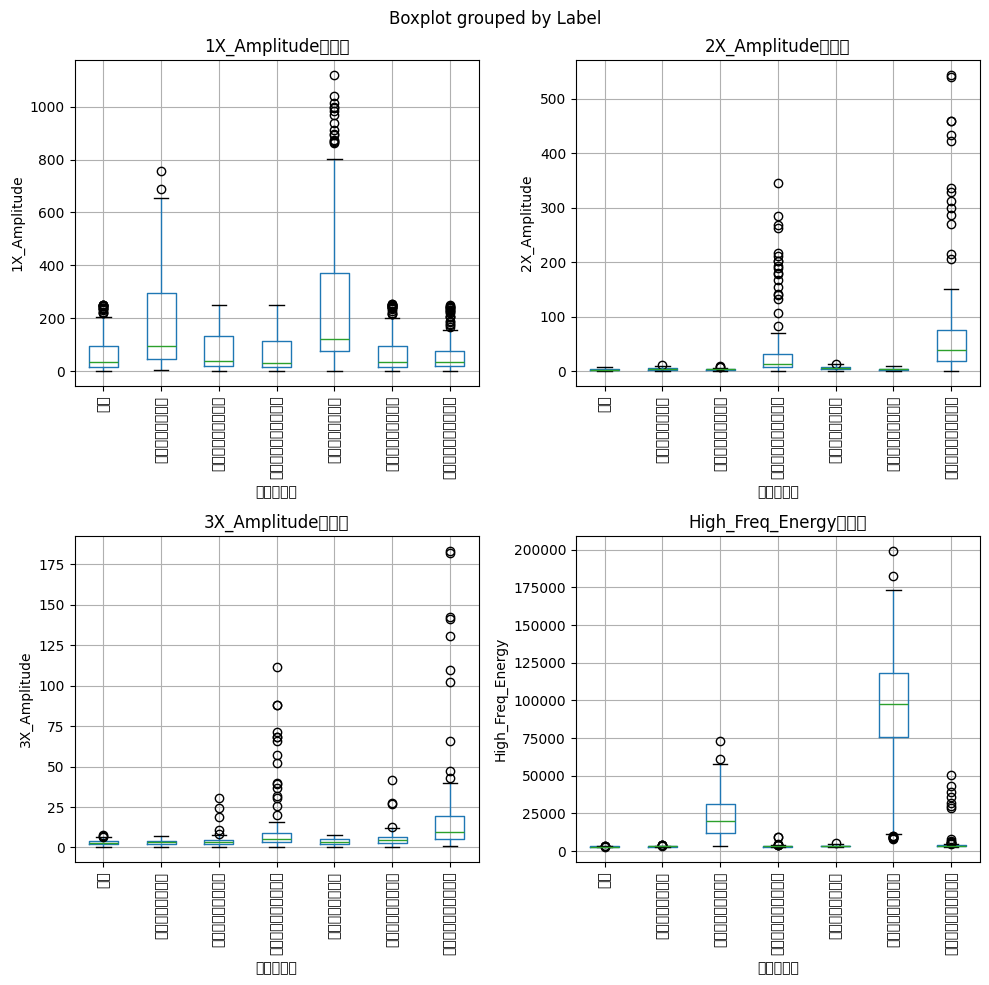

In [17]:


# 周波数領域の特徴量をリストとして定義
freq_features = [
    '1X_Amplitude',  # 基本周波数成分の振幅
    '2X_Amplitude',  # 2倍周波数成分の振幅
    '3X_Amplitude',  # 3倍周波数成分の振幅
    'High_Freq_Energy'  # 高周波成分のエネルギー
]
# 2行2列のサブプロットを作成
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()  # サブプロットを1次元配列に変換
# 各周波数領域の特徴量について、箱ひげ図を作成
for idx, feature in enumerate(freq_features):
    vibration_df.boxplot(
        column=feature,  # 箱ひげ図を作成する特徴量
        by='Label',  # ラベルごとにデータを分割
        ax=axes[idx]  # 対応するサブプロットに描画
    )
    axes[idx].set_title(f'{feature}の分布')  # サブプロットのタイトルを設定
    axes[idx].set_xlabel('故障タイプ')  # x軸のラベルを設定
    axes[idx].set_ylabel(feature)  # y軸のラベルを設定
    axes[idx].tick_params(axis='x', rotation=90)  # x軸のラベルを90度回転
# レイアウトを調整してプロットを表示
plt.tight_layout()
plt.show()

In [20]:
# vibration_dfから必要な列を抽出
target_df = vibration_df[feature_columns + ['RUL']]
# 数値列だけに絞る
numeric_df = target_df.select_dtypes(include='number')
# 相関行列を取得
corr_matrix = numeric_df.corr()
# RULとの相関のみ取り出し降順にソート
correlations = corr_matrix.loc[:, 'RUL'].drop('RUL').sort_values()
# 各特徴量とRULの相関係数を表示し、相関の強さを分類
print("残存寿命（RUL）との相関係数:")
print("="*50)
for feature, corr_value in correlations.items():
    print(f"{feature:20s}: {corr_value:+.3f}")
    if abs(corr_value) > 0.5:
        print(f"  → 強い相関あり（{'負' if corr_value < 0 else '正'}の相関）")
    elif abs(corr_value) > 0.3:
        print(f"  → 中程度の相関あり")
    else:
        print(f"  → 弱い相関")

残存寿命（RUL）との相関係数:
Peak                : -0.752
  → 強い相関あり（負の相関）
RMS                 : -0.556
  → 強い相関あり（負の相関）
Kurtosis            : -0.347
  → 中程度の相関あり
High_Freq_Energy    : -0.280
  → 弱い相関
Skewness            : -0.194
  → 弱い相関
2X_Amplitude        : -0.164
  → 弱い相関
3X_Amplitude        : -0.157
  → 弱い相関
1X_Amplitude        : -0.124
  → 弱い相関
Crest_Factor        : -0.089
  → 弱い相関


In [21]:
# 特徴量データ (X) とターゲット変数 (y) を設定
X = vibration_df[feature_columns]
y = vibration_df['RUL']
# データを訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
# 分割後のデータ数を表示
print(f"訓練データ数: {len(X_train)}")  # 訓練データのサンプル数
print(f"テストデータ数: {len(X_test)}")  # テストデータのサンプル数

訓練データ数: 745
テストデータ数: 249


In [22]:
# ランダムフォレストモデルのインスタンスを作成
rf_model = RandomForestRegressor(
    n_estimators=100,  # 決定木の数
    max_depth=10,  # 決定木の最大深さ
    min_samples_split=10,  # ノードを分割するために必要な最小サンプル数
    random_state=42  # 再現性のための乱数シード
)
# ランダムフォレストモデルを訓練データで学習
rf_model.fit(X_train, y_train)
# テストデータを用いて予測を実行
y_pred_rf = rf_model.predict(X_test)

NameError: name 'RandomForestRegressor' is not defined

In [23]:
# XGBoostモデルのインスタンスを作成
xgb_model = XGBRegressor(
    n_estimators=100,  # 決定木の数
    max_depth=6,  # 決定木の最大深さ
    learning_rate=0.1,  # 学習率
    random_state=42  # 再現性のための乱数シード
)
# XGBoostモデルを訓練データで学習
xgb_model.fit(X_train, y_train)
# テストデータを用いて予測を実行
y_pred_xgb = xgb_model.predict(X_test)

NameError: name 'XGBRegressor' is not defined

In [24]:
from sklearn.metrics import mean_absolute_error, r2_score
# ランダムフォレストモデルの平均絶対誤差(MAE)と決定係数(R2)を計算
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
# XGBoostモデルの平均絶対誤差(MAE)と決定係数(R2)を計算
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
# モデル性能を比較して出力
print("モデル性能比較:")
print("="*50)
print(f"RandomForest - MAE: {mae_rf:.2f}日, R2: {r2_rf:.3f}")
print(f"XGBoost     - MAE: {mae_xgb:.2f}日, R2: {r2_xgb:.3f}")
# MAEが小さい方のモデルを選択
if mae_rf < mae_xgb:
    selected_model = rf_model  # ランダムフォレストモデルを選択
    model_name = "RandomForest"
    y_pred = y_pred_rf
else:
    selected_model = xgb_model  # XGBoostモデルを選択
    model_name = "XGBoost"
    y_pred = y_pred_xgb
# 選択されたモデル名を出力
print(f"\n選択されたモデル: {model_name}")

NameError: name 'y_pred_rf' is not defined

In [25]:
# RUL（残存寿命）が10日未満であるにもかかわらず、
# 予測値が10日以上の場合をカウント（危険な見逃し）
critical_miss = np.sum((y_test < 10) &amp; (y_pred >= 10))
# RUL（残存寿命）が30日以上であるにもかかわらず、
# 予測値が10日未満の場合をカウント（過剰警告）
false_alarm = np.sum((y_test >= 30) &amp; (y_pred < 10))
# 安全性評価の結果を出力
print("安全性評価:")
print("="*50)
print(f"危険な見逃し（RUL<10日を見逃し）: {critical_miss}件")
print(f"過剰警告（RUL≥30日を危険と判定）: {false_alarm}件")
# 危険な見逃しの件数に応じた評価を出力
if critical_miss == 0:
    print("\n→ 優秀：危険な見逃しがありません")
elif critical_miss < 3:
    print("\n→ 良好：危険な見逃しが少ない")
else:
    print("\n→ 要改善：危険な見逃しが多い")

SyntaxError: invalid syntax (ipython-input-1108294732.py, line 3)